[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/monografia_modelos/blob/main/05_models_CNN.ipynb)

# Intento de usar CNN

In [1]:
try:
    import google.colab 
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/repos-especializacion-UdeA/monografia_modelos/refs/heads/main/init.py
    from init import init; init(force_download=False)
except ImportError:
    print("Ejecucion del notebook en entorno local")

Ejecucion del notebook en entorno local


## Objetivo a desarrollar

* Obtener diferentes modelos usando la caracteristica RMS

## Actividades

To Do...

## 1. Librerias y configuraciones previas

In [2]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

try:
    import umap
    print("La librería 'umap-learn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'umap-learn' no está instalada.")
    print("Instalando 'umap-learn'...")
    !pip install umap-learn

try:
    import tensorflow as tf
    print(f"La librería 'tensorflow' {tf.__version__} está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'tensorflow' no está instalada.")
    print("Instalando 'tensorflow'...")
    !pip install tensorflow

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.
La librería 'umap-learn' está instalada y se ha importado correctamente.
La librería 'tensorflow' 2.18.0 está instalada y se ha importado correctamente.


In [3]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal

# Bliblioteca de archivos
# ==============================================================================
import requests
from tqdm import tqdm
import os
import zipfile
import sys
import copy
import re

# Biblioteca libemg
# ==============================================================================
from libemg.data_handler import OfflineDataHandler, RegexFilter
from libemg.utils import get_windows
from libemg.feature_extractor import FeatureExtractor
from libemg import filtering

# Asumo que estas importaciones ya están en tu código:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from itertools import cycle
from sklearn.decomposition import PCA, KernelPCA
import umap

import tensorflow as tf
from tensorflow.keras.layers import (Input, LSTM, Conv1D, BatchNormalization,
                                     PReLU, Dropout, Flatten, Dense, GlobalAveragePooling1D)
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, balanced_accuracy_score

# 2. Funciones

In [4]:
def load_data_to_model_csv(directory_path):
    """
    Carga todos los archivos CSV de un directorio, identifica si son conjuntos balanceados o desbalanceados
    según el nombre del archivo, y agrupa los datos en dos diccionarios.

    Args:
        directory_path (str): Ruta al directorio que contiene archivos CSV.

    Returns:
        tuple: (dict_imbalanced, dict_balanced) donde cada diccionario contiene DataFrames indexados por un identificador extraído del nombre del archivo.
    """
    all_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    print(f"Archivos encontrados: {all_files}")

    dict_imbalanced = {}
    dict_balanced = {}

    for file in all_files:
        file_path = os.path.join(directory_path, file)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error leyendo el archivo {file}: {e}")
            continue

        print(f"Archivo: {file}")

        # Se asume que el identificador está antes del primer guion bajo
        feature = file.split('_')[0]
        feature = feature.split('.')[0]  # Elimina la extensión del archivo

        # Clasifica en el diccionario correspondiente
        if 'imbalanced' in file.lower():
            dict_imbalanced[feature] = df
        else:
            dict_balanced[feature] = df

        print(f"Datos cargados para '{feature}': {df.shape[0]} filas, {df.shape[1]} columnas")

    return dict_imbalanced, dict_balanced

## 3. Variables del entorno

In [5]:
ROOT_DIR =  './'
DATA_DIR =  ROOT_DIR + 'local/data/'
if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)    
RAW_DATA_DIR = DATA_DIR + 'raw'
if not os.path.exists(RAW_DATA_DIR):
    os.makedirs(RAW_DATA_DIR)
RAW_DATA_DIR_NPY = DATA_DIR + 'raw_numpy'
if not os.path.exists(RAW_DATA_DIR_NPY):
    os.makedirs(RAW_DATA_DIR_NPY)
RAW_SUBSET_DATA_DIR = DATA_DIR + 'raw_subset'
if not os.path.exists(RAW_SUBSET_DATA_DIR):
    os.makedirs(RAW_SUBSET_DATA_DIR)
FILTERED_SUBSET_DATA_DIR = DATA_DIR + 'filtered_subset'
if not os.path.exists(FILTERED_SUBSET_DATA_DIR):
    os.makedirs(FILTERED_SUBSET_DATA_DIR)
FEATURES_SUBSET_DATA_DIR = DATA_DIR + 'features_subset'
if not os.path.exists(FEATURES_SUBSET_DATA_DIR):
    os.makedirs(FEATURES_SUBSET_DATA_DIR)
FEATURES_SUBSET_BALANCED_DATA = DATA_DIR + 'features_subset_balanced'
if not os.path.exists(FEATURES_SUBSET_BALANCED_DATA):
    os.makedirs(FEATURES_SUBSET_BALANCED_DATA)

print("Directorio de trabajo:", ROOT_DIR)
print("Directorio de datos:", DATA_DIR)
print("Directorio de datos crudos:", RAW_DATA_DIR)
print("Directorio de datos crudos (numpy):", RAW_DATA_DIR_NPY)
print("Directorio de datos crudos (subconjunto):", RAW_SUBSET_DATA_DIR)
print("Directorio de datos filtrados (subconjunto):", FILTERED_SUBSET_DATA_DIR)
print("Directorio de datos de características (subconjunto):", FEATURES_SUBSET_DATA_DIR)
print("Directorio de datos de características (subconjunto balanceado):", FEATURES_SUBSET_BALANCED_DATA)

Directorio de trabajo: ./
Directorio de datos: ./local/data/
Directorio de datos crudos: ./local/data/raw
Directorio de datos crudos (numpy): ./local/data/raw_numpy
Directorio de datos crudos (subconjunto): ./local/data/raw_subset
Directorio de datos filtrados (subconjunto): ./local/data/filtered_subset
Directorio de datos de características (subconjunto): ./local/data/features_subset
Directorio de datos de características (subconjunto balanceado): ./local/data/features_subset_balanced


In [6]:
MODELS_DIR = ROOT_DIR + 'local/models'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

CLASSIFICARION_MODELS_DIR = MODELS_DIR + '/classification'
if not os.path.exists(CLASSIFICARION_MODELS_DIR):
    os.makedirs(CLASSIFICARION_MODELS_DIR)

SCALERS_DIR = MODELS_DIR + '/scalers'
if not os.path.exists(SCALERS_DIR):
    os.makedirs(SCALERS_DIR)

print("Directorio de modelos:", MODELS_DIR)
print("Directorio de modelos de clasificación:", CLASSIFICARION_MODELS_DIR)
print("Directorio de escaladores:", SCALERS_DIR)

Directorio de modelos: ./local/models
Directorio de modelos de clasificación: ./local/models/classification
Directorio de escaladores: ./local/models/scalers


## 4. Carga del dataset de las caracteristicas

Carga y combinación de los datos en un solo dataframe

In [7]:
FEATURES_SUBSET_BALANCED_DATA

'./local/data/features_subset_balanced'

El dataframe en el que se combinaron los datos fue: `merged_df` 

In [8]:
# Load and merge CSV files
dict_imbalanced, dict_balanced = load_data_to_model_csv(FEATURES_SUBSET_BALANCED_DATA)

Archivos encontrados: ['IAV_balanced.csv', 'IAV_imbalanced.csv', 'RMS_balanced.csv', 'RMS_imbalanced.csv', 'WL_balanced.csv', 'WL_imbalanced.csv']
Archivo: IAV_balanced.csv
Datos cargados para 'IAV': 13272 filas, 11 columnas
Archivo: IAV_imbalanced.csv
Datos cargados para 'IAV': 21594 filas, 14 columnas
Archivo: RMS_balanced.csv
Datos cargados para 'RMS': 13272 filas, 11 columnas
Archivo: RMS_imbalanced.csv
Datos cargados para 'RMS': 21594 filas, 14 columnas
Archivo: WL_balanced.csv
Datos cargados para 'WL': 13272 filas, 11 columnas
Archivo: WL_imbalanced.csv
Datos cargados para 'WL': 21594 filas, 14 columnas


En los diccionarios `dict_imbalanced`, `dict_balanced` estan las caracteristicas de las señales capturadas para cada usuario. El diccionario `dict_imbalanced` se usara luego para realizar un clustering para clasificación usando kmeans.

In [9]:
dict_imbalanced.keys()

dict_keys(['IAV', 'RMS', 'WL'])

In [10]:
for feature_name, df in dict_imbalanced.items():
    print(f"{feature_name}: {df.shape}")

IAV: (21594, 14)
RMS: (21594, 14)
WL: (21594, 14)


In [11]:
for feature_name, df in dict_balanced.items():
    print(f"{feature_name}: {df.shape}")

IAV: (13272, 11)
RMS: (13272, 11)
WL: (13272, 11)


### RMS

In [22]:
# Display the first few rows of the first DataFrame
df_rms_imbalanced = dict_imbalanced['RMS'].copy()
df_rms_imbalanced.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,restimulus,subject,restimulus_cat,subject_cat
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,0.0,10,0.0,10
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,0.0,10,0.0,10
2,0.214203,0.027382,0.070140,0.002309,0.002581,0.005600,0.146619,0.526502,0.002533,0.311813,-1.0,10,-1.0,10
3,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,1.0,10,1.0,10
4,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,1.0,10,1.0,10


In [23]:
df_rms_imbalanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21594 entries, 0 to 21593
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RMS_ch1         21594 non-null  float64
 1   RMS_ch2         21594 non-null  float64
 2   RMS_ch3         21594 non-null  float64
 3   RMS_ch4         21594 non-null  float64
 4   RMS_ch5         21594 non-null  float64
 5   RMS_ch6         21594 non-null  float64
 6   RMS_ch7         21594 non-null  float64
 7   RMS_ch8         21594 non-null  float64
 8   RMS_ch9         21594 non-null  float64
 9   RMS_ch10        21594 non-null  float64
 10  restimulus      21594 non-null  float64
 11  subject         21594 non-null  int64  
 12  restimulus_cat  21594 non-null  float64
 13  subject_cat     21594 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 2.3 MB


In [24]:
df_rms_imbalanced['restimulus_cat'] = df_rms_imbalanced['restimulus_cat'].astype('category')
df_rms_imbalanced['subject_cat'] = df_rms_imbalanced['subject_cat'].astype('category')
df_rms_imbalanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21594 entries, 0 to 21593
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   RMS_ch1         21594 non-null  float64 
 1   RMS_ch2         21594 non-null  float64 
 2   RMS_ch3         21594 non-null  float64 
 3   RMS_ch4         21594 non-null  float64 
 4   RMS_ch5         21594 non-null  float64 
 5   RMS_ch6         21594 non-null  float64 
 6   RMS_ch7         21594 non-null  float64 
 7   RMS_ch8         21594 non-null  float64 
 8   RMS_ch9         21594 non-null  float64 
 9   RMS_ch10        21594 non-null  float64 
 10  restimulus      21594 non-null  float64 
 11  subject         21594 non-null  int64   
 12  restimulus_cat  21594 non-null  category
 13  subject_cat     21594 non-null  category
dtypes: category(2), float64(11), int64(1)
memory usage: 2.0 MB


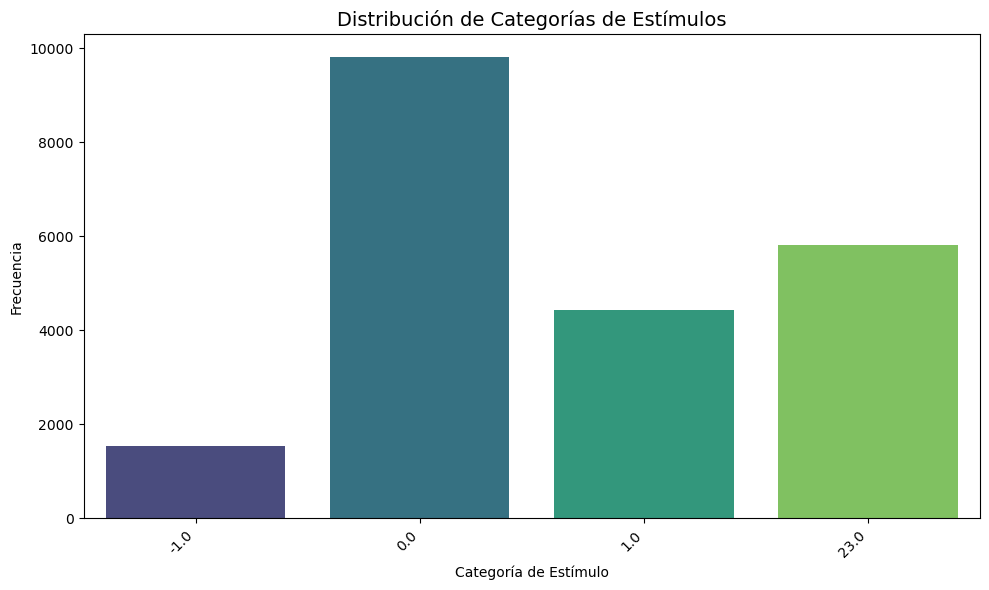

In [25]:
plt.figure(figsize=(10, 6)) # Tamaño mediano
sns.countplot(data=df_rms_imbalanced, x='restimulus', palette='viridis')
plt.title('Distribución de Categorías de Estímulos', fontsize=14) # Título resaltado
plt.xlabel('Categoría de Estímulo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Se eliminan todos los registros asociados a las ventanas cuya etiqueta se asocia a una transición

In [26]:
# Eliminar todas las filas donde restimulus_cat == -1 en fd_rms_imbalanced
df_rms_imbalanced = df_rms_imbalanced[df_rms_imbalanced['restimulus_cat'] != -1]
df_rms_imbalanced = df_rms_imbalanced.reset_index(drop=True)
df_rms_imbalanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20043 entries, 0 to 20042
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   RMS_ch1         20043 non-null  float64 
 1   RMS_ch2         20043 non-null  float64 
 2   RMS_ch3         20043 non-null  float64 
 3   RMS_ch4         20043 non-null  float64 
 4   RMS_ch5         20043 non-null  float64 
 5   RMS_ch6         20043 non-null  float64 
 6   RMS_ch7         20043 non-null  float64 
 7   RMS_ch8         20043 non-null  float64 
 8   RMS_ch9         20043 non-null  float64 
 9   RMS_ch10        20043 non-null  float64 
 10  restimulus      20043 non-null  float64 
 11  subject         20043 non-null  int64   
 12  restimulus_cat  20043 non-null  category
 13  subject_cat     20043 non-null  category
dtypes: category(2), float64(11), int64(1)
memory usage: 1.9 MB


En la siguiente grafica se verifica el procedimiento previo.

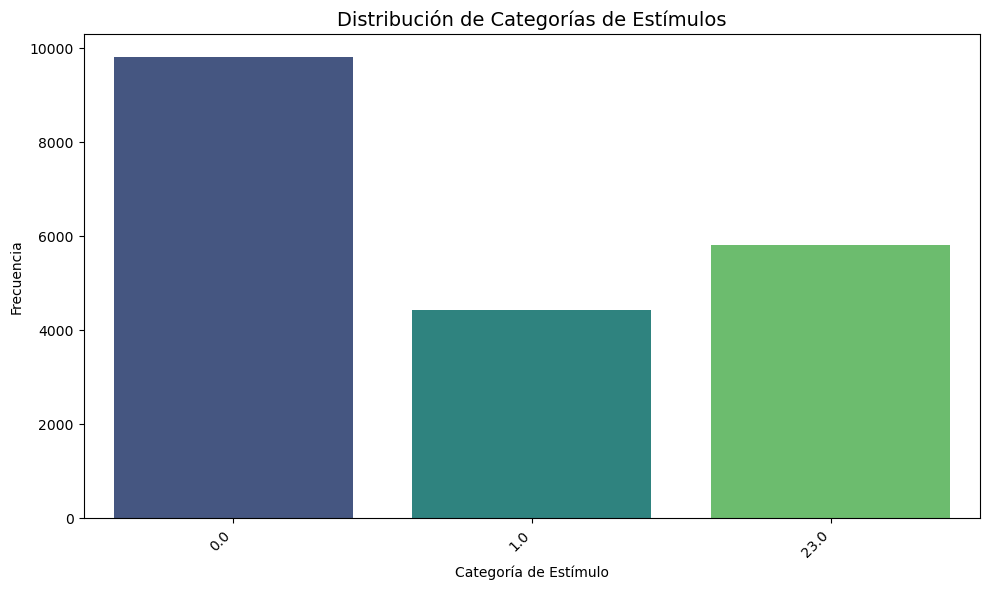

In [27]:
plt.figure(figsize=(10, 6)) # Tamaño mediano
sns.countplot(data=df_rms_imbalanced, x='restimulus', palette='viridis')
plt.title('Distribución de Categorías de Estímulos', fontsize=14) # Título resaltado
plt.xlabel('Categoría de Estímulo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
df_rms_imbalanced.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,restimulus,subject,restimulus_cat,subject_cat
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,0.0,10,0.0,10
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,0.0,10,0.0,10
2,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,1.0,10,1.0,10
3,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,1.0,10,1.0,10
4,0.955840,0.202396,0.380185,0.005046,0.008593,0.007723,0.239447,1.084849,0.013835,1.068361,1.0,10,1.0,10


In [29]:
# Contar los valores únicos en la columna 'restimulus'
unique_counts = df_rms_imbalanced['restimulus'].value_counts()

# Mostrar los resultados
print("Cantidad de datos únicos en 'restimulus':")
print(unique_counts)

Cantidad de datos únicos en 'restimulus':
restimulus
0.0     9809
23.0    5810
1.0     4424
Name: count, dtype: int64


In [30]:
df_rms_imbalanced = df_rms_imbalanced.drop(columns=['restimulus', 'subject', 'subject_cat'])
df_rms_imbalanced.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,restimulus_cat
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,0.0
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,0.0
2,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,1.0
3,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,1.0
4,0.955840,0.202396,0.380185,0.005046,0.008593,0.007723,0.239447,1.084849,0.013835,1.068361,1.0


### WL

In [31]:
# Display the first few rows of the first DataFrame
df_wl_imbalanced = dict_imbalanced['WL'].copy()
df_wl_imbalanced['restimulus_cat'] = df_wl_imbalanced['restimulus_cat'].astype('category')
df_wl_imbalanced['subject_cat'] = df_wl_imbalanced['subject_cat'].astype('category')

df_wl_imbalanced = df_wl_imbalanced[df_wl_imbalanced['restimulus_cat'] != -1]
df_wl_imbalanced = df_wl_imbalanced.reset_index(drop=True)
# Contar los valores únicos en la columna 'restimulus'
unique_counts = df_wl_imbalanced['restimulus'].value_counts()

# Mostrar los resultados
print("Cantidad de datos únicos en 'restimulus':")
print(unique_counts)

Cantidad de datos únicos en 'restimulus':
restimulus
0.0     9809
23.0    5810
1.0     4424
Name: count, dtype: int64


### IAV

In [32]:
# Display the first few rows of the first DataFrame
df_iav_imbalanced = dict_imbalanced['IAV'].copy()
df_iav_imbalanced['restimulus_cat'] = df_iav_imbalanced['restimulus_cat'].astype('category')
df_iav_imbalanced['subject_cat'] = df_iav_imbalanced['subject_cat'].astype('category')

df_iav_imbalanced = df_iav_imbalanced[df_iav_imbalanced['restimulus_cat'] != -1]
df_iav_imbalanced = df_iav_imbalanced.reset_index(drop=True)
# Contar los valores únicos en la columna 'restimulus'
unique_counts = df_iav_imbalanced['restimulus'].value_counts()

# Mostrar los resultados
print("Cantidad de datos únicos en 'restimulus':")
print(unique_counts)

Cantidad de datos únicos en 'restimulus':
restimulus
0.0     9809
23.0    5810
1.0     4424
Name: count, dtype: int64


## 5. Modelos

### 5.1. CNN + RMS

In [110]:
# Separar las entradas (features) y la salida (target)
X_rms = df_rms_imbalanced.drop(columns=['restimulus_cat'])  # Entradas
y_original = df_rms_imbalanced['restimulus_cat']  # Salida

# Mostrar las dimensiones de las entradas y la salida
print(f"Dimensiones de X (entradas): {X_rms.shape}")
print(f"Dimensiones de y (salida): {y_original.shape}")

Dimensiones de X (entradas): (20043, 10)
Dimensiones de y (salida): (20043,)


Remapeo de las etiquetas

In [111]:
# Mapeo de etiquetas a 0, 1, 2
label_mapping = {0.0: 0, 1.0: 1, 23.0: 2}
y = y_original.map(label_mapping)

Como las clases estan desbalanceadas, para asegurar que la proporción de clases en `y` se mantenga en el train y test se emplea el parametro `stratify`.


In [112]:
X_rms_train, X_rms_test, y_train, y_test = train_test_split(X_rms, y, test_size=0.2, random_state=42, stratify=y)

Escalado de datos

In [113]:
scaler = StandardScaler()
X_rms_train_scaled = scaler.fit_transform(X_rms_train)
X_rms_test_scaled = scaler.transform(X_rms_test)
print("Datos recargados y procesados.")

Datos recargados y procesados.


Remodelar X para la entrada del LSTM:
* `(n_muestras, 10) -> (n_muestras, 1, 10)` 
* `sequence_length = 1` 
* `num_features = 10`

In [114]:
X_rms_train_reshaped = X_rms_train_scaled.reshape((X_rms_train_scaled.shape[0], 1, X_rms_train_scaled.shape[1]))
X_rms_test_reshaped = X_rms_test_scaled.reshape((X_rms_test_scaled.shape[0], 1, X_rms_test_scaled.shape[1]))
print(f"Forma original de X_train_scaled: {X_rms_train_scaled.shape}")
print(f"Nueva forma de X_train_reshaped para LSTM: {X_rms_train_reshaped.shape}")

Forma original de X_train_scaled: (16034, 10)
Nueva forma de X_train_reshaped para LSTM: (16034, 1, 10)


Es necesario asegurar que los labels sean enteros.

In [115]:
if not np.array_equal(np.unique(y_train), np.array([0,1,2])):
    print("Mapeando etiquetas y_train, y_test a 0, 1, 2...")
    y_original_train_labels = y_train.copy() # Suponiendo que y_train es un pd.Series o np.array
    y_original_test_labels = y_test.copy()
        
    label_mapping = {0.0: 0, 1.0: 1, 23.0: 2} # Asegúrate que estos sean los valores en y_train/y_test
        
    if isinstance(y_train, pd.Series):
        y_train = y_train.map(label_mapping)
        y_test = y_test.map(label_mapping)
    else: # Suponiendo np.array
        # Es más robusto hacerlo si y_train es pd.Series con .map, o con un bucle si es np.array
        y_train = np.vectorize(label_mapping.get)(y_train)
        y_test = np.vectorize(label_mapping.get)(y_test)
            
    # Verificar si hay NaNs después del mapeo (si alguna etiqueta original no estaba en el mapping)
    if pd.Series(y_train).isnull().any() or pd.Series(y_test).isnull().any():
        print("¡Advertencia! Se encontraron NaNs después del mapeo de etiquetas. Verifica el label_mapping y los valores originales.")
    else:
        print("Etiquetas y_train, y_test mapeadas a 0, 1, 2.")
        print(f"Valores únicos en y_train después del mapeo: {np.unique(y_train)}")

Asegúrate que y_train contenga etiquetas enteras 0, 1, 2

In [116]:
unique_classes = np.unique(y_train)
print(f"Clases únicas para class_weight: {unique_classes}")

Clases únicas para class_weight: [0. 1. 2.]


El codigo del modelo lo genero skynet a partir del articulo **Hand Gesture Recognition Using Compact CNN via Surface Electromyography Signals** ([link](https://pmc.ncbi.nlm.nih.gov/articles/PMC7039218/)). La imagen base tomada fue la siguiente:

![imagen](https://cdn.ncbi.nlm.nih.gov/pmc/blobs/27cb/7039218/9dc477431943/sensors-20-00672-g002.jpg)

A continuación se muestra el codigo generado:

In [81]:
def build_lstm_cnn_model(input_shape, num_classes, lstm_units_1=64, lstm_units_2=64, fc_units=32):
    """
    Construye un modelo de Keras basado en el diagrama de arquitectura proporcionado.
    Args:
        input_shape (tuple): Forma de los datos de entrada (sequence_length, num_features).
        num_classes (int): Número de clases para la capa de salida Softmax.
        lstm_units_1 (int): Número de unidades en la primera capa LSTM.
        lstm_units_2 (int): Número de unidades en la segunda capa LSTM.
        fc_units (int): Número de unidades en la capa densa ("Fully Connected") antes de la PReLU.
    Returns:
        tensorflow.keras.models.Model: El modelo de Keras.
    """

    # Capa de Entrada
    inputs = Input(shape=input_shape, name="input_signals")

    # Capas LSTM
    # Dos capas LSTM apiladas. Ambas retornan secuencias completas.
    x = LSTM(units=lstm_units_1, return_sequences=True, name="lstm_1")(inputs)
    x = LSTM(units=lstm_units_2, return_sequences=True, name="lstm_2")(x)
    # Salida de LSTM: (batch_size, sequence_length, lstm_units_2)

    # Bloque 1DCNN
    # Primera sub-capa convolucional dentro del bloque 1DCNN
    cnn_output = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', name="conv1d_1")(x)
    cnn_output = BatchNormalization(name="batchnorm_1")(cnn_output)
    cnn_output = PReLU(name="prelu_1")(cnn_output)

    # Capa Dropout
    cnn_output = Dropout(0.3, name="dropout_1")(cnn_output)

    # Segunda sub-capa convolucional dentro del bloque 1DCNN
    cnn_output = Conv1D(filters=32, kernel_size=3, strides=1, padding='same', name="conv1d_2")(cnn_output)
    cnn_output = BatchNormalization(name="batchnorm_2")(cnn_output)
    cnn_output = PReLU(name="prelu_2")(cnn_output)
    # Salida del bloque 1DCNN: (batch_size, sequence_length, 32)

    # Pooling
    pooled_output = GlobalAveragePooling1D(name="global_avg_pooling")(cnn_output)
    # Salida de Pooling: (batch_size, 32)

    # Capa "Fully Connected"
    fc_output = Dense(units=fc_units, name="fully_connected_dense")(pooled_output)
    fc_output = PReLU(name="prelu_fc")(fc_output)
    # Salida de FC: (batch_size, fc_units)

    # Capa de Salida Softmax
    outputs = Dense(units=num_classes, activation='softmax', name="output_softmax")(fc_output)
    # Salida final: (batch_size, num_classes)

    # Crear el modelo
    model = Model(inputs=inputs, outputs=outputs, name="SequentialSignalClassifier_Adapted")

    return model

Instanciar y Compilar el Modelo

In [117]:
input_shape_for_model = (X_rms_train_reshaped.shape[1], X_rms_train_reshaped.shape[2]) # (1, 10)
num_classes = len(unique_classes) # Debería ser 3

model_lstm_cnn = build_lstm_cnn_model(
    input_shape=input_shape_for_model,
    num_classes=num_classes,
    lstm_units_1=64, # Se puede ajustar
    lstm_units_2=64,
    fc_units=32
)

model_lstm_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # Usamos sparse porque y_train son enteros (0,1,2)
    metrics=['accuracy'] # Podrías añadir tf.keras.metrics.Recall, etc.
)

model_lstm_cnn.summary()

Model: "SequentialSignalClassifier_Adapted"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_signals (InputLayer)      │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu_1 (PReLU)                 │ (None, 1, 64)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu_2 (PReLU)                 │ (None, 1, 32)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected_dense (Dense)   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu_fc (PReLU)                │ (None, 32)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,419 (282.89 KB)

 Trainable params: 72,227 (282.14 KB)

 Non-trainable params: 192 (768.00 B)

Entrenamiento del modelo

In [120]:
print("\nEntrenando el modelo (generado por skynet)...")
# Es buena idea usar un subconjunto para pruebas rápidas
epochs = 20 # Para una prueba rápida
batch_size = 32
history = model_lstm_cnn.fit(
                X_rms_train_reshaped, y_train,
                validation_data=(X_rms_test_reshaped, y_test),
                epochs=epochs,
                batch_size=batch_size,
                verbose=1
        )
print("Entrenamiento completado.")


Entrenando el modelo (generado por skynet)...
Epoch 1/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9307 - loss: 0.2033 - val_accuracy: 0.9424 - val_loss: 0.1739
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9286 - loss: 0.2058 - val_accuracy: 0.9364 - val_loss: 0.1799
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9314 - loss: 0.2054 - val_accuracy: 0.9399 - val_loss: 0.1770
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9255 - loss: 0.2232 - val_accuracy: 0.9359 - val_loss: 0.1782
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9253 - loss: 0.2170 - val_accuracy: 0.9416 - val_loss: 0.1756
Epoch 6/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9347 - loss: 0.1871 - val_accuracy: 0.9444 - val_loss: 0.1628
Epoch 7/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9292 - loss: 0.2055 - val_accuracy: 0.9454 - val_loss: 0.1648
Epoch 8/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc

Evaluación del modelo

In [121]:
print("\nEvaluando el modelo...")
loss, accuracy = model_lstm_cnn.evaluate(X_rms_test_reshaped, y_test, verbose=1)
print(f"Pérdida en Test: {loss:.4f}")
print(f"Exactitud en Test: {accuracy:.4f}")


Evaluando el modelo...
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9525 - loss: 0.1448
Pérdida en Test: 0.1485
Exactitud en Test: 0.9504


126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


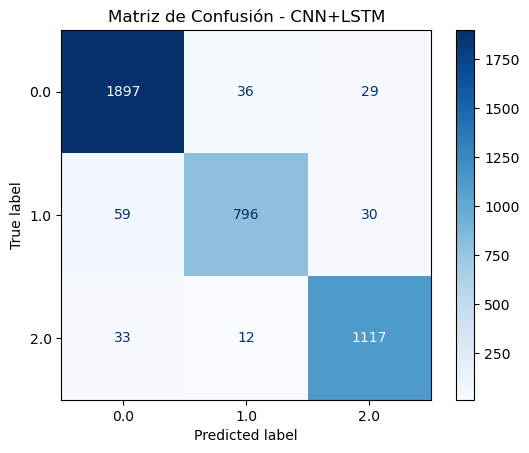

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener las predicciones del modelo
y_pred = model_lstm_cnn.predict(X_rms_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
cm_rms = confusion_matrix(y_test, y_pred_classes)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rms, display_labels=unique_classes)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - CNN+LSTM")
plt.show()

In [123]:
from sklearn.metrics import classification_report

# Calcular precision, recall, f1-score y support
report = classification_report(y_test, y_pred_classes, target_names=[str(cls) for cls in unique_classes])
print(report)

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      1962
         1.0       0.94      0.90      0.92       885
         2.0       0.95      0.96      0.96      1162

    accuracy                           0.95      4009
   macro avg       0.95      0.94      0.95      4009
weighted avg       0.95      0.95      0.95      4009



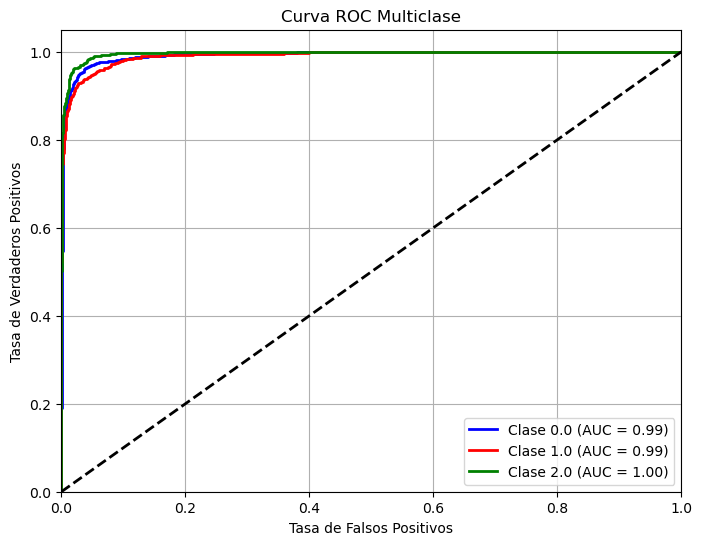

In [124]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarizar las etiquetas para ROC multicategoría
y_test_bin = label_binarize(y_test, classes=unique_classes)
# y_pred ya es la probabilidad de cada clase (salida softmax)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Clase {unique_classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 5.2. CNN + WL

In [132]:
# Separar las entradas (features) y la salida (target)
X_wl = df_wl_imbalanced.drop(columns=['restimulus_cat'])  # Entradas
y_original = df_wl_imbalanced['restimulus_cat']  # Salida

# Mostrar las dimensiones de las entradas y la salida
print(f"Dimensiones de X (entradas): {X_wl.shape}")
print(f"Dimensiones de y (salida): {y_original.shape}")

# Mapeo de etiquetas a 0, 1, 2
label_mapping = {0.0: 0, 1.0: 1, 23.0: 2}
y = y_original.map(label_mapping)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_wl_train, X_wl_test, y_train, y_test = train_test_split(X_wl, y, test_size=0.2, random_state=42, stratify=y)

# Escalar los datos
scaler = StandardScaler()
X_wl_train_scaled = scaler.fit_transform(X_wl_train)
X_wl_test_scaled = scaler.transform(X_wl_test)
print("Datos recargados y procesados.")

Dimensiones de X (entradas): (20043, 13)
Dimensiones de y (salida): (20043,)
Datos recargados y procesados.


In [133]:
# Redimensionar los datos para LSTM
X_wl_train_reshaped = X_wl_train_scaled.reshape((X_wl_train_scaled.shape[0], 1, X_wl_train_scaled.shape[1]))
X_wl_test_reshaped = X_wl_test_scaled.reshape((X_wl_test_scaled.shape[0], 1, X_wl_test_scaled.shape[1]))
print(f"Forma original de X_wl_train_scaled: {X_wl_train_scaled.shape}")
print(f"Nueva forma de X_wl_train_reshaped para LSTM: {X_wl_train_reshaped.shape}")

Forma original de X_wl_train_scaled: (16034, 13)
Nueva forma de X_wl_train_reshaped para LSTM: (16034, 1, 13)


In [134]:
unique_classes = np.unique(y_train)
print(f"Clases únicas para class_weight: {unique_classes}")

Clases únicas para class_weight: [0. 1. 2.]


In [135]:
input_shape_for_model = (X_wl_train_reshaped.shape[1], X_wl_train_reshaped.shape[2]) # (1, 10)
num_classes = len(unique_classes) # Debería ser 3


In [136]:
model_lstm_cnn_wl = build_lstm_cnn_model(
    input_shape=input_shape_for_model,
    num_classes=num_classes,
    lstm_units_1=64, # Se puede ajustar
    lstm_units_2=64,
    fc_units=32
)
model_lstm_cnn_wl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # Usamos sparse porque y_train son enteros (0,1,2)
    metrics=['accuracy'] # Podrías añadir tf.keras.metrics.Recall, etc.
)
model_lstm_cnn_wl.summary()

Model: "SequentialSignalClassifier_Adapted"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_signals (InputLayer)      │ (None, 1, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu_1 (PReLU)                 │ (None, 1, 64)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu_2 (PReLU)                 │ (None, 1, 32)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected_dense (Dense)   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu_fc (PReLU)                │ (None, 32)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,187 (285.89 KB)

 Trainable params: 72,995 (285.14 KB)

 Non-trainable params: 192 (768.00 B)

In [137]:
print("\nEntrenando el modelo (generado por skynet)...")
# Es buena idea usar un subconjunto para pruebas rápidas
epochs = 20 # Para una prueba rápida
batch_size = 32
history = model_lstm_cnn_wl.fit(
                X_wl_train_reshaped, y_train,
                validation_data=(X_wl_test_reshaped, y_test),
                epochs=epochs,
                batch_size=batch_size,
                verbose=1
        )
print("Entrenamiento completado.")


Entrenando el modelo (generado por skynet)...
Epoch 1/20


502/502 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8681 - loss: 0.3684 - val_accuracy: 0.9252 - val_loss: 0.2451
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9340 - loss: 0.1618 - val_accuracy: 0.9795 - val_loss: 0.0791
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9783 - loss: 0.0613 - val_accuracy: 0.9938 - val_loss: 0.0240
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9956 - loss: 0.0201 - val_accuracy: 0.8553 - val_loss: 0.2448
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9839 - loss: 0.0523 - val_accuracy: 0.9958 - val_loss: 0.0146
Epoch 6/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9943 - loss: 0.0198 - val_accuracy: 0.9980 - val_loss: 0.0088
Epoch 7/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9897 - loss: 0.0273 - val_accuracy: 0.9980 - val_loss: 0.0062
Epoch 8/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 0.9988 - va

In [138]:
print("\nEvaluando el modelo...")
loss, accuracy = model_lstm_cnn_wl.evaluate(X_wl_test_reshaped, y_test, verbose=1)
print(f"Pérdida en Test: {loss:.4f}")
print(f"Exactitud en Test: {accuracy:.4f}")


Evaluando el modelo...
 34/126 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9991 - loss: 0.0064  

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9991 - loss: 0.0047
Pérdida en Test: 0.0028
Exactitud en Test: 0.9993


126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


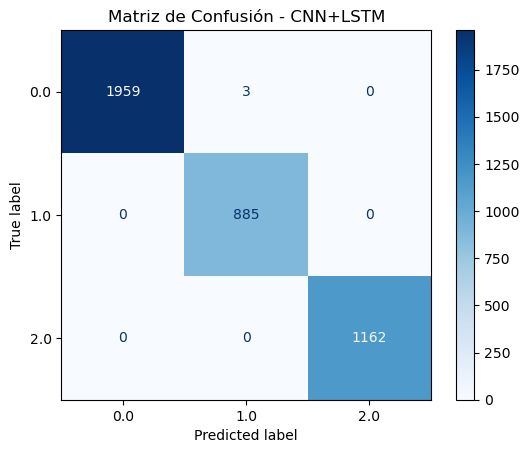

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener las predicciones del modelo
y_pred = model_lstm_cnn_wl.predict(X_wl_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
cm_wl = confusion_matrix(y_test, y_pred_classes)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_wl, display_labels=unique_classes)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - CNN+LSTM")
plt.show()

In [140]:
# Calcular precision, recall, f1-score y support
report = classification_report(y_test, y_pred_classes, target_names=[str(cls) for cls in unique_classes])
print(report)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1962
         1.0       1.00      1.00      1.00       885
         2.0       1.00      1.00      1.00      1162

    accuracy                           1.00      4009
   macro avg       1.00      1.00      1.00      4009
weighted avg       1.00      1.00      1.00      4009



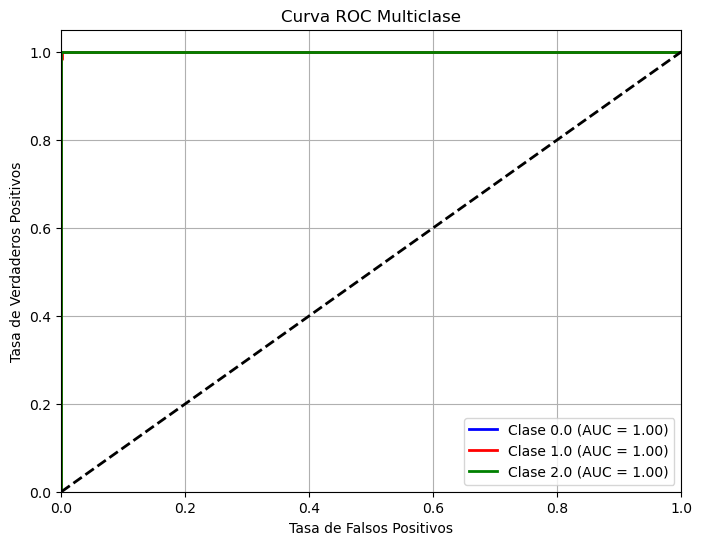

In [141]:
# Binarizar las etiquetas para ROC multicategoría
y_test_bin = label_binarize(y_test, classes=unique_classes)
# y_pred ya es la probabilidad de cada clase (salida softmax)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Clase {unique_classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase')
plt.legend(loc="lower right")
plt.grid()
plt.show()



In [142]:
# Guardar el modelo entrenado en formato HDF5
model_path = f"{CLASSIFICARION_MODELS_DIR}/model_lstm_cnn_wl.h5"
model_lstm_cnn_wl.save(model_path)
print(f"Modelo guardado en: {model_path}")

Modelo guardado en: ./local/models/classification/model_lstm_cnn_wl.h5


### 5.3. CNN + IAV

In [143]:
# Separar las entradas (features) y la salida (target)
X_iav = df_iav_imbalanced.drop(columns=['restimulus_cat'])  # Entradas
y_original = df_iav_imbalanced['restimulus_cat']  # Salida

# Mostrar las dimensiones de las entradas y la salida
print(f"Dimensiones de X (entradas): {X_iav.shape}")
print(f"Dimensiones de y (salida): {y_original.shape}")

# Mapeo de etiquetas a 0, 1, 2
label_mapping = {0.0: 0, 1.0: 1, 23.0: 2}
y = y_original.map(label_mapping)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_iav_train, X_iav_test, y_train, y_test = train_test_split(X_iav, y, test_size=0.2, random_state=42, stratify=y)

# Escalar los datos
scaler = StandardScaler()
X_iav_train_scaled = scaler.fit_transform(X_iav_train)
X_iav_test_scaled = scaler.transform(X_iav_test)
print("Datos recargados y procesados.")

Dimensiones de X (entradas): (20043, 13)
Dimensiones de y (salida): (20043,)
Datos recargados y procesados.


In [144]:
# Redimensionar los datos para LSTM
X_iav_train_reshaped = X_iav_train_scaled.reshape((X_iav_train_scaled.shape[0], 1, X_iav_train_scaled.shape[1]))
X_iav_test_reshaped = X_iav_test_scaled.reshape((X_iav_test_scaled.shape[0], 1, X_iav_test_scaled.shape[1]))
print(f"Forma original de X_iav_train_scaled: {X_iav_train_scaled.shape}")
print(f"Nueva forma de X_iav_train_reshaped para LSTM: {X_iav_train_reshaped.shape}")

Forma original de X_iav_train_scaled: (16034, 13)
Nueva forma de X_iav_train_reshaped para LSTM: (16034, 1, 13)


In [145]:
unique_classes = np.unique(y_train)
print(f"Clases únicas para class_weight: {unique_classes}")

Clases únicas para class_weight: [0. 1. 2.]


In [146]:
input_shape_for_model = (X_wl_train_reshaped.shape[1], X_wl_train_reshaped.shape[2]) # (1, 10)
num_classes = len(unique_classes) # Debería ser 3

model_lstm_cnn_iav = build_lstm_cnn_model(
    input_shape=input_shape_for_model,
    num_classes=num_classes,
    lstm_units_1=64, # Se puede ajustar
    lstm_units_2=64,
    fc_units=32
)
model_lstm_cnn_iav.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # Usamos sparse porque y_train son enteros (0,1,2)
    metrics=['accuracy'] # Podrías añadir tf.keras.metrics.Recall, etc.
)
model_lstm_cnn_iav.summary()

Model: "SequentialSignalClassifier_Adapted"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_signals (InputLayer)      │ (None, 1, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu_1 (PReLU)                 │ (None, 1, 64)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu_2 (PReLU)                 │ (None, 1, 32)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected_dense (Dense)   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu_fc (PReLU)                │ (None, 32)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,187 (285.89 KB)

 Trainable params: 72,995 (285.14 KB)

 Non-trainable params: 192 (768.00 B)

In [147]:
print("\nEntrenando el modelo (generado por skynet)...")
# Es buena idea usar un subconjunto para pruebas rápidas
epochs = 20 # Para una prueba rápida
batch_size = 32
history = model_lstm_cnn_iav.fit(
                X_iav_train_reshaped, y_train,
                validation_data=(X_iav_test_reshaped, y_test),
                epochs=epochs,
                batch_size=batch_size,
                verbose=1
        )
print("Entrenamiento completado.")


Entrenando el modelo (generado por skynet)...
Epoch 1/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8768 - loss: 0.3539 - val_accuracy: 0.9274 - val_loss: 0.2872
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9542 - loss: 0.1275 - val_accuracy: 0.9618 - val_loss: 0.0821
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9875 - loss: 0.0374 - val_accuracy: 0.9980 - val_loss: 0.0203
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9932 - loss: 0.0201 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9963 - loss: 0.0121 - val_accuracy: 0.9935 - val_loss: 0.0220
Epoch 6/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9946 - loss: 0.0147 - val_accuracy: 0.9998 - val_loss: 5.7671e-04
Epoch 7/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9988 - loss: 0.0054 - val_accuracy: 0.9998 - val_loss: 0.0025
Epoch 8/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/

In [148]:
print("\nEvaluando el modelo...")
loss, accuracy = model_lstm_cnn_iav.evaluate(X_iav_test_reshaped, y_test, verbose=1)
print(f"Pérdida en Test: {loss:.4f}")
print(f"Exactitud en Test: {accuracy:.4f}")


Evaluando el modelo...
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.2493e-05
Pérdida en Test: 0.0000
Exactitud en Test: 1.0000


126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


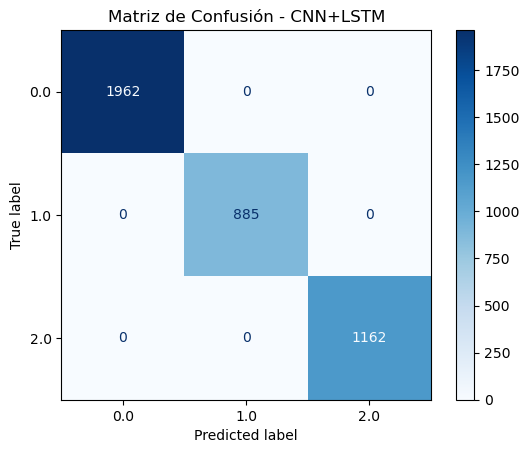

In [149]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener las predicciones del modelo
y_pred = model_lstm_cnn_iav.predict(X_iav_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
cm_iav = confusion_matrix(y_test, y_pred_classes)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_iav, display_labels=unique_classes)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - CNN+LSTM")
plt.show()

In [150]:
# Calcular precision, recall, f1-score y support
report = classification_report(y_test, y_pred_classes, target_names=[str(cls) for cls in unique_classes])
print(report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1962
         1.0       1.00      1.00      1.00       885
         2.0       1.00      1.00      1.00      1162

    accuracy                           1.00      4009
   macro avg       1.00      1.00      1.00      4009
weighted avg       1.00      1.00      1.00      4009



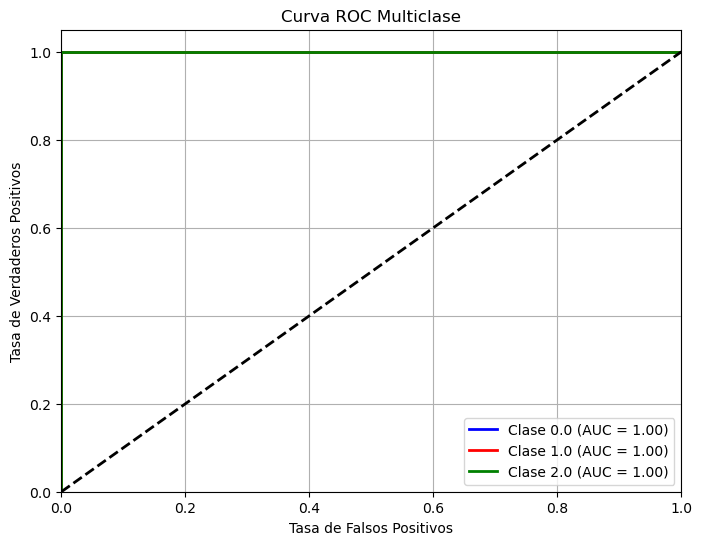

In [151]:
# Binarizar las etiquetas para ROC multicategoría
y_test_bin = label_binarize(y_test, classes=unique_classes)
# y_pred ya es la probabilidad de cada clase (salida softmax)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Clase {unique_classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [152]:
# Guardar el modelo entrenado en formato HDF5
model_path = f"{CLASSIFICARION_MODELS_DIR}/model_lstm_cnn_iav.h5"
model_lstm_cnn_iav.save(model_path)
print(f"Modelo guardado en: {model_path}")

Modelo guardado en: ./local/models/classification/model_lstm_cnn_iav.h5
